In [26]:
from keras import Sequential, Input
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
#import keras_tuner as kt
import os

ModuleNotFoundError: No module named 'tensorflow.python.keras.preprocessing'

## Image scaling

In [2]:
train_datagen = ImageDataGenerator(rescale=1 / 255,
                                   rotation_range=360,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1 / 255)

In [5]:
target_size = (64, 64)
batch_size = 32
train_data_dir = './data/food11/train'

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(train_data_dir, target_size=target_size,
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         subset='validation')

test_generator = test_datagen.flow_from_directory('./data/food11/test',
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  class_mode='categorical')

Found 7920 images belonging to 11 classes.
Found 1980 images belonging to 11 classes.
Found 1100 images belonging to 11 classes.


## Training

In [8]:
cnn = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=train_generator.image_shape),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.2),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.2),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Conv2D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(rate=.2),
    Flatten(),
    Dropout(rate=.2),
    Dense(units=256, activation='relu'),
    BatchNormalization(),
    Dropout(rate=.2),
    Dense(units=11, activation='softmax')
])

cnn.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics='accuracy')
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_7 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 batch_normalization_8 (Batc  (None, 60, 60, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                      

In [13]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

callbacks = [
    EarlyStopping(min_delta=.005, monitor='val_accuracy', patience=10, restore_best_weights=True)
]

history = cnn.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    batch_size=32,
                    epochs=15,
                    validation_data=validation_generator,
                    validation_steps=validation_steps)

Epoch 1/15
247/247 [==============================] - 62s 249ms/step - loss: 1.3514 - accuracy: 0.5493 - val_loss: 1.8656 - val_accuracy: 0.4073
Epoch 2/15
247/247 [==============================] - 63s 254ms/step - loss: 1.3113 - accuracy: 0.5664 - val_loss: 1.9228 - val_accuracy: 0.3986
Epoch 3/15
247/247 [==============================] - 63s 254ms/step - loss: 1.2581 - accuracy: 0.5879 - val_loss: 1.9441 - val_accuracy: 0.4206
Epoch 4/15
247/247 [==============================] - 63s 255ms/step - loss: 1.2033 - accuracy: 0.6060 - val_loss: 1.4866 - val_accuracy: 0.5200
Epoch 5/15
247/247 [==============================] - 66s 267ms/step - loss: 1.1701 - accuracy: 0.6171 - val_loss: 1.8953 - val_accuracy: 0.4493
Epoch 6/15
247/247 [==============================] - 62s 252ms/step - loss: 1.1468 - accuracy: 0.6202 - val_loss: 2.0679 - val_accuracy: 0.4073
Epoch 7/15
247/247 [==============================] - 67s 269ms/step - loss: 1.1103 - accuracy: 0.6337 - val_loss: 1.4741 - val_ac

<AxesSubplot:>

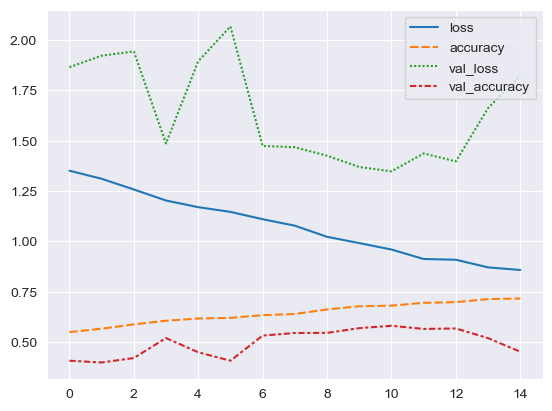

In [14]:
import seaborn as sns
sns.lineplot(data=history.history)

In [29]:
from keras.preprocessing import image
import numpy as np
def prepare_image(path):
    img = image.load_img(path, target_size=target_size)
    img_array = image.img_to_array(img) / 255
    return np.expand_dims(img_array, axis=0)

In [30]:
cnn.predict(prepare_image('./data/pizza.png'))

AttributeError: module 'keras.preprocessing.image' has no attribute 'load_img'

## Finding a better model

In [ ]:
def create_model(hp: kt.HyperParameters):
    model = Sequential([
        Input(shape=train_generator.image_shape)
    ])

    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)
    first_filters = hp.Choice('first_filters', values=[16, 32, 64])
    conv_layers = hp.Int('conv_layers', min_value=1, max_value=3, step=1)

    for i in range(conv_layers):
        model.add(Conv2D(filters=2 ** i * first_filters, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(filters=2 ** i * first_filters, kernel_size=3, activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(rate=dropout))

    model.add(Flatten())
    model.add(Dropout(rate=dropout))

    dense_layers = hp.Int('dense_layers', min_value=1, max_value=3, step=1)
    dense_units = hp.Choice('dense_units', values=[64, 128, 256])

    for i in range(dense_layers):
        model.add(Dense(units=dense_units, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(rate=dropout))

    model.add(Dense(units=1, activation='sigmoid'))

    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     directory=os.path.normpath('C:/'),
                     project_name='')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5)
]

tuner.search(train_generator,
             steps_per_epoch=steps_per_epoch,
             epochs=20,
             callbacks=callbacks,
             validation_data=validation_generator,
             validation_steps=validation_steps)